# The Boston Light Swim temperature analysis with Python

In the past we demonstrated how to perform a CSW catalog search with [`OWSLib`](https://ioos.github.io/notebooks_demos//notebooks/2016-12-19-exploring_csw),
and how to obtain near real-time data with [`pyoos`](https://ioos.github.io/notebooks_demos//notebooks/2016-10-12-fetching_data).
In this notebook we will use both to find all observations and model data around the Boston Harbor to access the sea water temperature.


This workflow is part of an example to advise swimmers of the annual [Boston lighthouse swim](http://bostonlightswim.org/) of the Boston Harbor water temperature conditions prior to the race. For more information regarding the workflow presented here see [Signell, Richard P.; Fernandes, Filipe; Wilcox, Kyle.   2016. "Dynamic Reusable Workflows for Ocean Science." *J. Mar. Sci. Eng.* 4, no. 4: 68](http://dx.doi.org/10.3390/jmse4040068).

In [1]:
import warnings

# Suppresing warnings for a "pretty output."
warnings.simplefilter('ignore')

This notebook is quite big and complex,
so to help us keep things organized we'll define a cell with the most important options and switches.

Below we can define the date,
bounding box, phenomena `SOS` and `CF` names and units,
and the catalogs we will search.

In [2]:
%%writefile config.yaml

# Specify a YYYY-MM-DD hh:mm:ss date or integer day offset.
# If both start and stop are offsets they will be computed relative to datetime.today() at midnight.
# Use the dates commented below to reproduce the last Boston Light Swim event forecast.
date:
    start: -5 # 2016-8-16 00:00:00
    stop: +4 # 2016-8-29 00:00:00

run_name: 'latest'

# Boston harbor.
region:
    bbox: [-71.3, 42.03, -70.57, 42.63]
    # Try the bounding box below to see how the notebook will behave for a different region.
    #bbox: [-74.5, 40, -72., 41.5]
    crs: 'urn:ogc:def:crs:OGC:1.3:CRS84'

sos_name: 'sea_water_temperature'

cf_names:
    - sea_water_temperature
    - sea_surface_temperature
    - sea_water_potential_temperature
    - equivalent_potential_temperature
    - sea_water_conservative_temperature
    - pseudo_equivalent_potential_temperature

units: 'celsius'

catalogs:
    - https://data.ioos.us/csw

Overwriting config.yaml


We'll print some of the search configuration options along the way to keep track of them.

In [3]:
import os
import shutil
from datetime import datetime
from ioos_tools.ioos import parse_config

config = parse_config('config.yaml')

# Saves downloaded data into a temporary directory.
save_dir = os.path.abspath(config['run_name'])
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)

fmt = '{:*^64}'.format
print(fmt('Saving data inside directory {}'.format(save_dir)))
print(fmt(' Run information '))
print('Run date: {:%Y-%m-%d %H:%M:%S}'.format(datetime.utcnow()))
print('Start: {:%Y-%m-%d %H:%M:%S}'.format(config['date']['start']))
print('Stop: {:%Y-%m-%d %H:%M:%S}'.format(config['date']['stop']))
print('Bounding box: {0:3.2f}, {1:3.2f},'
      '{2:3.2f}, {3:3.2f}'.format(*config['region']['bbox']))

Saving data inside directory /home/filipe/IOOS/notebooks_demos/notebooks/latest
*********************** Run information ************************
Run date: 2019-02-06 19:46:20
Start: 2019-02-01 00:00:00
Stop: 2019-02-10 00:00:00
Bounding box: -71.30, 42.03,-70.57, 42.63


We already created an `OWSLib.fes` filter [before](https://ioos.github.io/notebooks_demos//notebooks/2016-12-19-exploring_csw).
The main difference here is that we do not want the atmosphere model data,
so we are filtering out all the `GRIB-2` data format.

In [4]:
def make_filter(config):
    from owslib import fes
    from ioos_tools.ioos import fes_date_filter
    kw = dict(wildCard='*', escapeChar='\\',
              singleChar='?', propertyname='apiso:AnyText')

    or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                      for val in config['cf_names']])

    not_filt = fes.Not([fes.PropertyIsLike(literal='GRIB-2', **kw)])

    begin, end = fes_date_filter(config['date']['start'],
                                 config['date']['stop'])
    bbox_crs = fes.BBox(config['region']['bbox'],
                        crs=config['region']['crs'])
    filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]
    return filter_list


filter_list = make_filter(config)

In the cell below we ask the catalog for all the returns that match the filter and have an OPeNDAP endpoint.

In [5]:
from ioos_tools.ioos import service_urls, get_csw_records
from owslib.csw import CatalogueServiceWeb


dap_urls = []
print(fmt(' Catalog information '))
for endpoint in config['catalogs']:
    print('URL: {}'.format(endpoint))
    try:
        csw = CatalogueServiceWeb(endpoint, timeout=120)
    except Exception as e:
        print('{}'.format(e))
        continue
    csw = get_csw_records(csw, filter_list, esn='full')
    OPeNDAP = service_urls(csw.records, identifier='OPeNDAP:OPeNDAP')
    odp = service_urls(csw.records, identifier='urn:x-esri:specification:ServiceType:odp:url')
    dap = OPeNDAP + odp
    dap_urls.extend(dap)

    print('Number of datasets available: {}'.format(len(csw.records.keys())))

    for rec, item in csw.records.items():
        print('{}'.format(item.title))
    if dap:
        print(fmt(' DAP '))
        for url in dap:
            print('{}.html'.format(url))
    print('\n')

# Get only unique endpoints.
dap_urls = list(set(dap_urls))

********************* Catalog information **********************
URL: https://data.ioos.us/csw
Number of datasets available: 33
ROMS doppio Real-Time Operational PSAS Forecast System Version 1 FMRC Averages
ROMS doppio Real-Time Operational PSAS Forecast System Version 1 FMRC History
urn:ioos:station:NOAA.NOS.CO-OPS:8443970 station, Boston, MA
A01 Accelerometer - Waves
A01 Directional Waves (waves.mstrain Experimental)
A01 Met - Meteorology
A01 Optics - Chlorophyll / Turbidity
A01 Optode - Oxygen
A01 SBE16 Oxygen
A01 Sbe37 - CTD
BOSTON 16 NM East of Boston, MA
Buoy A01 - Massachusetts Bay
COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)
Coupled Northwest Atlantic Prediction System (CNAPS)
Department of Physical Oceanography, School of Marine Sciences, University of Maine A01 Accelerometer Buoy Sensor
Department of Physical Oceanography, School of Marine Sciences, University of Maine A01 Met Buoy Sensor
Department of Physical Oceanography, School of Marine Science

We found some models, and observations from NERACOOS there.
However, we do know that there are some buoys from NDBC and CO-OPS available too.
Also, those NERACOOS observations seem to be from a [CTD](http://www.neracoos.org/thredds/dodsC/UMO/DSG/SOS/A01/CTD1m/HistoricRealtime/Agg.ncml.html) mounted at 65 meters below the sea surface. Rendering them useless from our purpose.

So let's use the catalog only for the models by filtering the observations with `is_station` below.
And we'll rely `CO-OPS` and `NDBC` services for the observations.

In [6]:
from timeout_decorator import TimeoutError
from ioos_tools.ioos import is_station

# Filter out some station endpoints.
non_stations = []
for url in dap_urls:
    url = f'{url}#fillmismatch'
    try:
        if not is_station(url):
            non_stations.append(url)
    except (IOError, OSError, RuntimeError, TimeoutError) as e:
        print('Could not access URL {}.html\n{!r}'.format(url, e))

dap_urls = non_stations

print(fmt(' Filtered DAP '))
for url in dap_urls:
    print('{}.html'.format(url))

************************* Filtered DAP *************************
http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc#fillmismatch.html
http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_BOSTON_FORECAST.nc#fillmismatch.html
http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.optode.realtime.51m.nc#fillmismatch.html
http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.accelerometer.realtime.nc#fillmismatch.html
http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.met.realtime.nc#fillmismatch.html
http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best#fillmismatch.html
http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/his/History_Best#fillmismatch.html
http://thredds.secoora.org/thredds/dodsC/AOOS_OSTIA.nc#fillmismatch.html
http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.sbe37.realtime.

Now we can use `pyoos` collectors for `NdbcSos`,

In [7]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos

collector_ndbc = NdbcSos()

collector_ndbc.set_bbox(config['region']['bbox'])
collector_ndbc.end_time = config['date']['stop']
collector_ndbc.start_time = config['date']['start']
collector_ndbc.variables = [config['sos_name']]

ofrs = collector_ndbc.server.offerings
title = collector_ndbc.server.identification.title
print(fmt(' NDBC Collector offerings '))
print('{}: {} offerings'.format(title, len(ofrs)))

******************* NDBC Collector offerings *******************
National Data Buoy Center SOS: 1037 offerings


In [8]:
import pandas as pd
from ioos_tools.ioos import collector2table

ndbc = collector2table(collector=collector_ndbc,
                       config=config,
                       col='sea_water_temperature (C)')

if ndbc:
    data = dict(
        station_name=[s._metadata.get('station_name') for s in ndbc],
        station_code=[s._metadata.get('station_code') for s in ndbc],
        sensor=[s._metadata.get('sensor') for s in ndbc],
        lon=[s._metadata.get('lon') for s in ndbc],
        lat=[s._metadata.get('lat') for s in ndbc],
        depth=[s._metadata.get('depth') for s in ndbc],
    )

table = pd.DataFrame(data).set_index('station_code')
table

,station_name,sensor,lon,lat,depth
station_code,,,,,
44013,"BOSTON 16 NM East of Boston, MA",urn:ioos:sensor:wmo:44013::watertemp1,-70.651,42.346,0.6


and `CoopsSos`.

In [9]:
from pyoos.collectors.coops.coops_sos import CoopsSos

collector_coops = CoopsSos()

collector_coops.set_bbox(config['region']['bbox'])
collector_coops.end_time = config['date']['stop']
collector_coops.start_time = config['date']['start']
collector_coops.variables = [config['sos_name']]

ofrs = collector_coops.server.offerings
title = collector_coops.server.identification.title
print(fmt(' Collector offerings '))
print('{}: {} offerings'.format(title, len(ofrs)))

********************* Collector offerings **********************
NOAA.NOS.CO-OPS SOS: 1230 offerings


In [10]:
coops = collector2table(collector=collector_coops,
                        config=config,
                        col='sea_water_temperature (C)')

if coops:
    data = dict(
        station_name=[s._metadata.get('station_name') for s in coops],
        station_code=[s._metadata.get('station_code') for s in coops],
        sensor=[s._metadata.get('sensor') for s in coops],
        lon=[s._metadata.get('lon') for s in coops],
        lat=[s._metadata.get('lat') for s in coops],
        depth=[s._metadata.get('depth') for s in coops],
    )

table = pd.DataFrame(data).set_index('station_code')
table

,station_name,sensor,lon,lat,depth
station_code,,,,,
44013,"BOSTON 16 NM East of Boston, MA",urn:ioos:sensor:wmo:44013::watertemp1,-70.651,42.346,0.6


We will join all the observations into an uniform series, interpolated to 1-hour interval, for the model-data comparison.

This step is necessary because the observations can be 7 or 10 minutes resolution,
while the models can be 30 to 60 minutes.

In [11]:
data = ndbc + coops

index = pd.date_range(start=config['date']['start'].replace(tzinfo=None),
                      end=config['date']['stop'].replace(tzinfo=None),
                      freq='1H')

# Preserve metadata with `reindex`.
observations = []
for series in data:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    observations.append(obs)

In this next cell we will save the data for quicker access later.

In [12]:
import iris
from ioos_tools.tardis import series2cube

attr = dict(
    featureType='timeSeries',
    Conventions='CF-1.6',
    standard_name_vocabulary='CF-1.6',
    cdm_data_type='Station',
    comment='Data from http://opendap.co-ops.nos.noaa.gov'
)


cubes = iris.cube.CubeList(
    [series2cube(obs, attr=attr) for obs in observations]
)

outfile = os.path.join(save_dir, 'OBS_DATA.nc')
iris.save(cubes, outfile)

Taking a quick look at the observations:

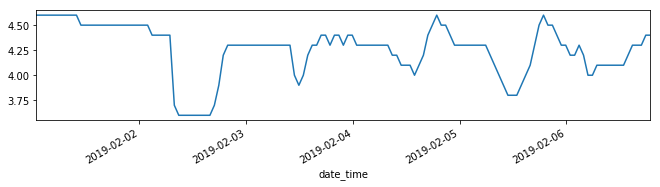

In [13]:
%matplotlib inline

ax = pd.concat(data).plot(figsize=(11, 2.25))

Now it is time to loop the models we found above,

In [14]:
from iris.exceptions import (CoordinateNotFoundError, ConstraintMismatchError,
                             MergeError)
from ioos_tools.ioos import get_model_name
from ioos_tools.tardis import quick_load_cubes, proc_cube, is_model, get_surface

print(fmt(' Models '))
cubes = dict()
for k, url in enumerate(dap_urls):
    print('\n[Reading url {}/{}]: {}'.format(k+1, len(dap_urls), url))
    try:
        cube = quick_load_cubes(url, config['cf_names'],
                                callback=None, strict=True)
        if is_model(cube):
            cube = proc_cube(cube,
                             bbox=config['region']['bbox'],
                             time=(config['date']['start'],
                                   config['date']['stop']),
                             units=config['units'])
        else:
            print('[Not model data]: {}'.format(url))
            continue
        cube = get_surface(cube)
        mod_name = get_model_name(url)
        cubes.update({mod_name: cube})
    except (RuntimeError, ValueError,
            ConstraintMismatchError, CoordinateNotFoundError,
            IndexError) as e:
        print('Cannot get cube for: {}\n{}'.format(url, e))

**************************** Models ****************************

[Reading url 1/13]: http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc#fillmismatch

[Reading url 2/13]: http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_BOSTON_FORECAST.nc#fillmismatch

[Reading url 3/13]: http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.optode.realtime.51m.nc#fillmismatch
[Not model data]: http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.optode.realtime.51m.nc#fillmismatch

[Reading url 4/13]: http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.accelerometer.realtime.nc#fillmismatch
Cannot get cube for: http://www.neracoos.org/thredds/dodsC/UMO/Realtime/SOS/A01/DSG_A0140.accelerometer.realtime.nc#fillmismatch
Cannot find ['sea_water_temperature', 'sea_surface_temperature', 'sea_water_potential_temperature', 'equivalent_potential_temperature', 'sea_wa

Next, we will match them with the nearest observed time-series. The `max_dist=0.08` is in degrees, that is roughly 8 kilometers.

In [15]:
import iris
from iris.pandas import as_series
from ioos_tools.tardis import (make_tree, get_nearest_water,
                               add_station, ensure_timeseries, remove_ssh)

for mod_name, cube in cubes.items():
    fname = '{}.nc'.format(mod_name)
    fname = os.path.join(save_dir, fname)
    print(fmt(' Downloading to file {} '.format(fname)))
    try:
        tree, lon, lat = make_tree(cube)
    except CoordinateNotFoundError:
        print('Cannot make KDTree for: {}'.format(mod_name))
        continue
    # Get model series at observed locations.
    raw_series = dict()
    for obs in observations:
        obs = obs._metadata
        station = obs['station_code']
        try:
            kw = dict(k=10, max_dist=0.08, min_var=0.01)
            args = cube, tree, obs['lon'], obs['lat']
            try:
                series, dist, idx = get_nearest_water(*args, **kw)
            except RuntimeError as e:
                print('Cannot download {!r}.\n{}'.format(cube, e))
                series = None
        except ValueError:
            status = 'No Data'
            print('[{}] {}'.format(status, obs['station_name']))
            continue
        if not series:
            status = 'Land   '
        else:
            raw_series.update({station: series})
            series = as_series(series)
            status = 'Water  '
        print('[{}] {}'.format(status, obs['station_name']))
    if raw_series:  # Save cube.
        for station, cube in raw_series.items():
            cube = add_station(cube, station)
            cube = remove_ssh(cube)
        try:
            cube = iris.cube.CubeList(raw_series.values()).merge_cube()
        except MergeError as e:
            print(e)
        ensure_timeseries(cube)
        try:
            iris.save(cube, fname)
        except AttributeError:
            # FIXME: we should patch the bad attribute instead of removing everything.
            cube.attributes = {}
            iris.save(cube, fname)
        del cube
    print('Finished processing [{}]'.format(mod_name))

[Water  ] BOSTON 16 NM East of Boston, MA
Finished processing [Forecasts-NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc#fillmismatch]
[No Data] BOSTON 16 NM East of Boston, MA
Finished processing [Forecasts-NECOFS_FVCOM_OCEAN_BOSTON_FORECAST.nc#fillmismatch]
[Water  ] BOSTON 16 NM East of Boston, MA
Finished processing [roms_doppio_2017_da_avg-Averages_Best#fillmismatch]
[Water  ] BOSTON 16 NM East of Boston, MA
Finished processing [roms_doppio_2017_da-History_Best#fillmismatch]
[Water  ] BOSTON 16 NM East of Boston, MA
Finished processing [SECOORA_NCSU_CNAPS.nc#fillmismatch]
[No Data] BOSTON 16 NM East of Boston, MA
Finished processing [Forecasts-NECOFS_FVCOM_OCEAN_SCITUATE_FORECAST.nc#fillmismatch]


Now it is possible to compute some simple comparison metrics. First we'll calculate the model mean bias:

$$ \text{MB} = \mathbf{\overline{m}} - \mathbf{\overline{o}}$$

In [16]:
from ioos_tools.ioos import stations_keys


def rename_cols(df, config):
    cols = stations_keys(config, key='station_name')
    return df.rename(columns=cols)

In [17]:
from ioos_tools.ioos import load_ncs
from ioos_tools.skill_score import mean_bias, apply_skill

dfs = load_ncs(config)

df = apply_skill(dfs, mean_bias, remove_mean=False, filter_tides=False)
skill_score = dict(mean_bias=df.to_dict())

# Filter out stations with no valid comparison.
df.dropna(how='all', axis=1, inplace=True)
df = df.applymap('{:.2f}'.format).replace('nan', '--')

And the root mean squared rrror of the deviations from the mean:
$$ \text{CRMS} = \sqrt{\left(\mathbf{m'} - \mathbf{o'}\right)^2}$$

where: $\mathbf{m'} = \mathbf{m} - \mathbf{\overline{m}}$ and $\mathbf{o'} = \mathbf{o} - \mathbf{\overline{o}}$

In [18]:
from ioos_tools.skill_score import rmse

dfs = load_ncs(config)

df = apply_skill(dfs, rmse, remove_mean=True, filter_tides=False)
skill_score['rmse'] = df.to_dict()

# Filter out stations with no valid comparison.
df.dropna(how='all', axis=1, inplace=True)
df = df.applymap('{:.2f}'.format).replace('nan', '--')

The next 2 cells make the scores "pretty" for plotting.

In [19]:
import pandas as pd

# Stringfy keys.
for key in skill_score.keys():
    skill_score[key] = {str(k): v for k, v in skill_score[key].items()}

mean_bias = pd.DataFrame.from_dict(skill_score['mean_bias'])
mean_bias = mean_bias.applymap('{:.2f}'.format).replace('nan', '--')

skill_score = pd.DataFrame.from_dict(skill_score['rmse'])
skill_score = skill_score.applymap('{:.2f}'.format).replace('nan', '--')

In [20]:
import folium
from ioos_tools.ioos import get_coordinates


def make_map(bbox, **kw):
    line = kw.pop('line', True)
    layers = kw.pop('layers', True)
    zoom_start = kw.pop('zoom_start', 5)

    lon = (bbox[0] + bbox[2]) / 2
    lat = (bbox[1] + bbox[3]) / 2
    m = folium.Map(width='100%', height='100%',
                   location=[lat, lon], zoom_start=zoom_start)

    if layers:
        url = 'http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km'
        w = folium.WmsTileLayer(
            url,
            name='Sea Surface Temperature',
            fmt='image/png',
            layers='CRW_SST',
            attr='PacIOOS TDS',
            overlay=True,
            transparent=True)
        w.add_to(m)

    if line:
        p = folium.PolyLine(
            get_coordinates(bbox),
            color='#FF0000',
            weight=2,
            opacity=0.9,
        )
        p.add_to(m)
    return m

In [21]:
bbox = config['region']['bbox']

m = make_map(
    bbox,
    zoom_start=11,
    line=True,
    layers=True
)

The cells from `[20]` to `[25]` create a [`folium`](https://github.com/python-visualization/folium) map with [`bokeh`](http://bokeh.pydata.org/en/latest/) for the time-series at the observed points.

Note that we did mark the nearest model cell location used in the comparison.

In [22]:
all_obs = stations_keys(config)

from glob import glob
from operator import itemgetter

import iris
from folium.plugins import MarkerCluster

iris.FUTURE.netcdf_promote = True

big_list = []
for fname in glob(os.path.join(save_dir, '*.nc')):
    if 'OBS_DATA' in fname:
        continue
    cube = iris.load_cube(fname)
    model = os.path.split(fname)[1].split('-')[-1].split('.')[0]
    lons = cube.coord(axis='X').points
    lats = cube.coord(axis='Y').points
    stations = cube.coord('station_code').points
    models = [model]*lons.size
    lista = zip(models, lons.tolist(), lats.tolist(), stations.tolist())
    big_list.extend(lista)

big_list.sort(key=itemgetter(3))
df = pd.DataFrame(big_list, columns=['name', 'lon', 'lat', 'station'])
df.set_index('station', drop=True, inplace=True)
groups = df.groupby(df.index)


locations, popups = [], []
for station, info in groups:
    sta_name = all_obs[station]
    for lat, lon, name in zip(info.lat, info.lon, info.name):
        locations.append([lat, lon])
        popups.append('[{}]: {}'.format(name, sta_name))

MarkerCluster(locations=locations, popups=popups, name='Cluster').add_to(m);

Here we use a dictionary with some models we expect to find so we can create a better legend for the plots. If any new models are found, we will use its filename in the legend as a default until we can go back and add a short name to our library.

In [23]:
titles = {
    'coawst_4_use_best': 'COAWST_4',
    'global': 'HYCOM',
    'NECOFS_GOM3_FORECAST': 'NECOFS_GOM3',
    'NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST': 'NECOFS_MassBay',
    'OBS_DATA': 'Observations'
}

In [24]:
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.models import HoverTool
from itertools import cycle
from bokeh.palettes import Category20

from folium import IFrame

# Plot defaults.
colors = Category20[20]
colorcycler = cycle(colors)
tools = 'pan,box_zoom,reset'
width, height = 750, 250


def make_plot(df, station):
    p = figure(
        toolbar_location='above',
        x_axis_type='datetime',
        width=width,
        height=height,
        tools=tools,
        title=str(station)
    )
    for column, series in df.iteritems():
        series.dropna(inplace=True)
        if not series.empty:
            if 'OBS_DATA' not in column:
                bias = mean_bias[str(station)][column]
                skill = skill_score[str(station)][column]
                line_color = next(colorcycler)
                kw = dict(alpha=0.65, line_color=line_color)
            else:
                skill = bias = 'NA'
                kw = dict(alpha=1, color='crimson')
            line = p.line(
                x=series.index,
                y=series.values,
                legend='{}'.format(titles.get(column, column)),
                line_width=5,
                line_cap='round',
                line_join='round',
                **kw
            )
            p.add_tools(HoverTool(tooltips=[('Name', '{}'.format(titles.get(column, column))),
                                            ('Bias', bias),
                                            ('Skill', skill)],
                                  renderers=[line]))
    return p


def make_marker(p, station):
    lons = stations_keys(config, key='lon')
    lats = stations_keys(config, key='lat')

    lon, lat = lons[station], lats[station]
    html = file_html(p, CDN, station)
    iframe = IFrame(html, width=width+40, height=height+80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=[lat, lon],
                           popup=popup,
                           icon=icon)
    return marker

In [25]:
dfs = load_ncs(config)

for station in dfs:
    sta_name = all_obs[station]
    df = dfs[station]
    if df.empty:
        continue
    p = make_plot(df, station)
    marker = make_marker(p, station)
    marker.add_to(m)

folium.LayerControl().add_to(m)

m

Now we can navigate the map and click on the markers to explorer our findings.

The green markers locate the observations locations. They pop-up an interactive plot with the time-series and scores for the models (hover over the lines to se the scores). The blue markers indicate the nearest model grid point found for the comparison.